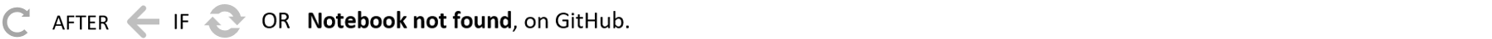

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)

# Wikipedia Notable Life Expectancy

## Notebook 4:  Data Cleaning Part 3

### Contents

This notebook covers:
- Extracting Nationality Continued:
    - Removing extra characters
    - Extracting `place1` and `place2` from:  
        - `info_1`
        - `info_2`
        - Other `info_` columns
        - Assigning `place_1` for "CIA" and "IRA"
- Removing Remaining Digits and Nationality/Country Values from `info_` Columns
- Correcting `place_2` Values for entries with "American Indian"
- Exporting partially cleaned dataset to SQLite database
- Saving `nation_map_dict` to a Pickle File


### Instructions
Options for Running this Notebook:
1. Clone the repository:   
    - Delete the following files that are generated by this notebook:
        - [wp_life_expect_clean3.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean3.db)
        - [nation_map.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_map.pkl)
    - Navigate to the cloned repository in Jupyter and open the notebook to run it.
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).
2. Save the notebook and database file below to the same working directory:<sup>1</sup>
    - Download the notebook:
        - Click on <kbd>Raw</kbd> above.
        - Save <kbd>Ctrl</kbd> + <kbd>S</kbd>
    - Follow the link to the database and pickle files and click <kbd>Download</kbd>, then move files to the same directory as the notebook:
        - [wp_life_expect_clean2.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean2.db)<sup>2</sup>
        - [nation_country_dict.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_country_dict.pkl)<sup>3</sup>
    - In Jupyter, navigate to the directory in which the notebook and files are saved to open and run the notebook.  
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).

    

### Data Dictionary for Loaded Version of Dataset
- **day**:  Day of the month of the individual's death
- **name**:  Name of the individual
- **info**:  Combined Wikipedia-defined fields:
> Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference.<sup>4</sup>
>
- **link**:  Link to an individual's page
- **num_references**:  Number of references for individual's page
- **year**: Year of the individual's death
- **month**: Month of the individual's death
- **info_parenth**: Parenthetical contents previously in info column
- **info_1** through **info_11**: Resultant remaining columns of split of info column on commas (info_0 already exhausted and dropped)
- **age**: Age of individual at death in years
- **cause_of_death**: Cause of death of individual

## Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean2.db), Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean2.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean2", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 21 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,British dancer,ballet designer and director,None,None,None,None,None,None,None,None,86.0,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,Irish economist,writer,and academic,None,None,None,None,None,None,None,68.0,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,(1980),None,Russian volleyball player,Olympic champion and coach,None,None,None,None,None,None,None,None,69.0,None
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,Chinese engineer,member of the Chinese Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death
74702,4,Jamaluddin Jarjis,", 63, Malaysian politician, MP for Rompin , helicopter crash.",https://en.wikipedia.org/wiki/Jamaluddin_Jarjis,15,2015,April,(since 1990),None,Malaysian politician,MP for Rompin,helicopter crash,None,None,None,None,None,None,None,63.0,None
50146,30,Dina Golan,", 65, Israeli singer and actress, cancer.",https://en.wikipedia.org/wiki/Dina_Golan,4,2011,June,None,None,Israeli singer and actress,cancer,None,None,None,None,None,None,None,None,65.0,None
46483,13,Jim Greenwood,", 81, Scottish rugby player.",https://en.wikipedia.org/wiki/Jim_Greenwood_(rugby_union),11,2010,September,None,None,Scottish rugby player,None,None,None,None,None,None,None,None,None,81.0,None
90719,21,Helmut Hofmann,", 91, German Olympic boxer .",https://en.wikipedia.org/wiki/Helmut_Hofmann,2,2017,August,(1952),None,German Olympic boxer,None,None,None,None,None,None,None,None,None,91.0,None
25704,16,Stephen Terrell,", 88, British barrister and politician, President of the Liberal Party.",https://en.wikipedia.org/wiki/Stephen_Terrell,4,2004,August,None,None,British barrister and politician,President of the Liberal Party,None,None,None,None,None,None,None,None,88.0,None


<IPython.core.display.Javascript object>

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   day             132652 non-null  object 
 1   name            132652 non-null  object 
 2   info            132652 non-null  object 
 3   link            132652 non-null  object 
 4   num_references  132652 non-null  object 
 5   year            132652 non-null  int64  
 6   month           132652 non-null  object 
 7   info_parenth    49830 non-null   object 
 8   info_1          35 non-null      object 
 9   info_2          132604 non-null  object 
 10  info_3          62571 non-null   object 
 11  info_4          12605 non-null   object 
 12  info_5          1497 non-null    object 
 13  info_6          216 non-null     object 
 14  info_7          31 non-null      object 
 15  info_8          6 non-null       object 
 16  info_9          1 non-null       object 
 17  info_10   

<IPython.core.display.Javascript object>

#### Loading [`nation_country_dict`](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_country_dict.pkl) from Pickle File to Dictionary `nation_map`

In [6]:
# Load the nation_country_dict
with open("nation_country_dict.pkl", "rb") as f:
    nation_map = pickle.load(f)

<IPython.core.display.Javascript object>

#### Function to Save Indices of Rows Matching Regular Expressions Pattern to a List and Print Number of Rows with Match 

In [7]:
# Define a function that takes dataframe, column name, and re pattern as arguments and returns list of indices
# for which column value matches re pattern
def rows_with_pattern(dataframe, column, pattern):
    """
    Takes input of dataframe, column name, and re pattern 
    and returns list of indices for rows that contain match
    for pattern anywhere within value for given column.
    
    dataframe: dataframe
    column: column name
    pattern: re pattern
    """
    index_list = []

    for i in dataframe.index:
        item = dataframe.loc[i, column]
        match = re.search(pattern, item)
        if match:
            index_list.append(i)
    print(
        f"There are {len(index_list)} rows with matching pattern in column '{column}'."
    )
    return index_list

<IPython.core.display.Javascript object>

#### Function to Use `rows_with_pattern` Function for Multiple Regular Expression Patterns

In [8]:
# Define a function that calls rows_with_pattern function for multiple re patterns
# returning a single list of indices for all rows with any pattern match


def multiple_patterns(dataframe, column, patterns):
    """
    Takes input dataframe, column, and list of re patterns and returns single list 
    of indices for rows in which a match for any pattern is found with re.search
    
    dataframe: dataframe
    column: column name
    patterns: list of re patterns
    """
    rows_combined = []

    # For loop to check each pattern
    for pattern in patterns:

        # List and number of rows matching each pattern
        print(pattern)
        rows_to_check = rows_with_pattern(dataframe, column, pattern)
        print("")

        # Add list for each pattern to combined list
        rows_combined += rows_to_check

    return rows_combined

<IPython.core.display.Javascript object>

## Extracting Nationality Continued
Here is the approach we will take:
- The plan will be to save the country name, in lieu of nationality, in new `place_1` and `place_2` columns as it is standardized for the various associated nationality values.
- First, we will update the keys and values in `nation_map` by replacing hyphens with a single space.
- Then we will remove "-born" from the column we are searching, as well as replace "-" and "/" each with single spaces.  In this step, we can also remove leading and trailing periods and whitespace.
- We will proceed to search the numbered `info_` columns in order, checking as follows:
    1. if column value starts with a value in the dictionary:
        - save country to `place_1` and remove value from searched column.
    2. if `place_1` value has been found:
        - if updated column value starts with a value in the dictionary:
            - save country to `place_2` and remove value from searched column.
    3. Repeat steps 1 and 2 but comparing with country (dictionary keys)
    4. Check unique values for column starting with capital letters.
- It is tempting to shorten the process by simply searching for nationality and country values within the column value, but as there are entries containing first and second nationality, we have to proceed from left to right to extract these values optimally.
- To avoid extracting incorrect values for a person who studies a place, rather than being from that place (e.g., "Egypt" vs "Egyptologist"), we will search for the exact value and the value with a single trailing space.

#### Examining `nation_map`

In [9]:
# Examining nation_map
nation_map

{'Afghan': 'Afghanistan',
 'Albanian': 'Albania',
 'Algerian': 'Algeria',
 'Andorran': 'Andorra',
 'Angolan': 'Angola',
 'Antiguan': 'Antigua and Barbuda',
 'Barbudan': 'Antigua and Barbuda',
 'Argentine': 'Argentina',
 'Armenian': 'Armenia',
 'Australian': 'Australia',
 'Austrian': 'Austria',
 'Azerbaijani': 'Azerbaijan',
 'Azeri': 'Azerbaijan',
 'Bahamian': 'The Bahamas',
 'Bahraini': 'Bahrain',
 'Bengali': 'Bangladesh',
 'Barbadian': 'Barbados',
 'Belarusian': 'Belarus',
 'Belgian': 'Belgium',
 'Belizean': 'Belize',
 'Beninese': 'Benin',
 'Beninois': 'Benin',
 'Bhutanese': 'Bhutan',
 'Bolivian': 'Bolivia',
 'Bosnian': 'Bosnia and Herzegovina',
 'Herzegovinian': 'Bosnia and Herzegovina',
 'Motswana': 'Botswana',
 'Botswanan': 'Botswana',
 'Brazilian': 'Brazil',
 'Bruneian': 'Brunei',
 'Bulgarian': 'Bulgaria',
 'Burkinabé': 'Burkina Faso',
 'Burmese': 'Burma',
 'Burundian': 'Burundi',
 'Cabo Verdean': 'Cabo Verde',
 'Cambodian': 'Cambodia',
 'Cameroonian': 'Cameroon',
 'Canadian': 'Ca

<IPython.core.display.Javascript object>

#### Removing "-" and "." from `nation_map`

In [10]:
# Removing hyphens from nation_map
nation_map = {
    key.replace("-", ""): value.replace("-", " ") for key, value in nation_map.items()
}

# Removing periods from nation_map
nation_map = {key.replace(".", ""): value for key, value in nation_map.items()}

<IPython.core.display.Javascript object>

#### Removing or Replacing Extra Characters in `info_` Columns

In [11]:
%%time

# List of columns to treat
cols_lst = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
    'info_parenth'
]

# Dictionary of keys to find and values to replace keys
replace_dict = {'-born': '', '–born': '', '-bred': '', '–bred': '', '-': ' ', '–': ' ', '/': ' ', '.': ' ', '(': '', ')': '', "'s": '', "   ": ' ', '  ': ' '}

# For loop to find and replace characters in replace_dict in columns in cols_list
# and strip any leading or trailing periods or whitespace
for column in cols_lst:
    for key, value in replace_dict.items():
        for index in df[column].notna().index:
            item = df.loc[index, column]
            if item:
                df.loc[index, column] = item.replace(key, value).strip()

CPU times: total: 3min 46s
Wall time: 3min 47s


<IPython.core.display.Javascript object>

<a id=place a></a>

#### Initializing `place_1` and `place_2` Columns

In [12]:
# Initializing place_1 and place_2
df[["place_1", "place_2"]] = None

# Checking a sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
27411,24,Fei Xiaotong,", 94, Chinese researcher and professor of sociology and anthropology.",https://en.wikipedia.org/wiki/Fei_Xiaotong,6,2005,April,None,None,Chinese researcher and professor of sociology and anthropology,None,None,None,None,None,None,None,None,None,94.0,None,None,None


<IPython.core.display.Javascript object>

#### Checking `info_1` for `place_1`

In [13]:
# Column to check
column = "info_1"

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[column].notna()) & df[extract_to].isna()]
    for index in dataframe.index:
        item = df.loc[index, column]
        if (
            item == nationality
            or item == country
            or item.startswith(nationality + " ")
            or item.startswith(country + " ")
        ):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column]
                .replace(nationality, "")
                .strip()
                .replace(country, "")
                .strip()
            )

# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
99212,5,Kenneth Roy,", 73. Scottish broadcaster and writer.",https://en.wikipedia.org/wiki/Kenneth_Roy,2,2018,November,None,broadcaster and writer,None,None,None,None,None,None,None,None,None,None,73.0,None,Scotland,None
55331,5,Lucky Diamond,", Maltese 15, American Guinness World Record dog, holder , cancer.",https://en.wikipedia.org/wiki/Lucky_Diamond_(dog),13,2012,June,dog most photographed with celebrities,,American Guinness World Record dog,holder,cancer,None,None,None,None,None,None,None,15.0,None,Malta,None


<IPython.core.display.Javascript object>

#### Observations:
- `info_1` provides us a small sample on which to test code.
- We successfully extracted those `place_1` values, now we will do the same on the treated rows for `place_2`.

#### Checking `info_1` for `place_2`

In [14]:
# Column to check
column = "info_1"

# Extract to column
extract_to = "place_2"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df["place_1"].notna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if (
            item == nationality
            or item == country
            or item.startswith(nationality + " ")
            or item.startswith(country + " ")
        ):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column]
                .replace(nationality, "")
                .strip()
                .replace(country, "")
                .strip()
            )

# Check a sample of rows
df.sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
34905,18,Don Chevrier,", 69, Canadian sportscaster.",https://en.wikipedia.org/wiki/Don_Chevrier,2,2007,December,None,None,Canadian sportscaster,None,None,None,None,None,None,None,None,None,69.0,None,None,None
28444,18,Marv Grissom,", 87, American baseball player and coach.",https://en.wikipedia.org/wiki/Marv_Grissom,12,2005,September,None,None,American baseball player and coach,None,None,None,None,None,None,None,None,None,87.0,None,None,None


<IPython.core.display.Javascript object>

#### Observations:
- Let us check the remaining unique values in `info_1`.

#### Checking Remaining Unique Values in `info_1`

In [15]:
# Checking unique values
df["info_1"].unique()

array([None, 'politician', 'Olympic sprinter', 'gridiron football player',
       'writer', 'businessman', 'social psychologist', 'King of Nepal',
       'Maori leader', 'artist', 'English sports journalist',
       'Jules Engel', 'early', 'aka', 'Jr', 'professional wrestler',
       'automotive engineer', 'materials scientist', 'weightlifter',
       'common chimpanzee', '', 'Olympic athlete', 'actor',
       'Olympic gymnast', 'broadcaster and writer', 'Olympic swimmer',
       'Olympic boxer', 'Olympic wrestler', 'Olympic sailor',
       'basketball player', 'college basketball coach',
       'choral conductor', 'Tree of the Year'], dtype=object)

<IPython.core.display.Javascript object>

#### Obsservations:
- Neither "English" nor "Maori" are keys in the current dictionary.
- Maori is an ethnicity within the country of New Zealand, so for now, we will add it as a key our dictionary with the country value of New Zealand.  If we have matching first and second countries, we can later remove the duplicate value.
- We will also add the key "English" with the country value "United Kingdom of Great Britain and Northern Ireland".
- Then, we can rerun the above code for `place_1` and `place_2`.

#### Updating `nation_map`

In [16]:
# Adding key: country pairs to nation_map
nation_map["English"] = nation_map["British"]
nation_map["Maori"] = nation_map["New Zealand"]

<IPython.core.display.Javascript object>

#### Re-checking `info_1` for `place_1`

In [17]:
# Column to check
column = "info_1"

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if (
            item == nationality
            or item == country
            or item.startswith(nationality + " ")
            or item.startswith(country + " ")
        ):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column]
                .replace(nationality, "")
                .strip()
                .replace(country, "")
                .strip()
            )

# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
17841,28,Marie Jahoda,", 94 Austrian-British social psychologist.",https://en.wikipedia.org/wiki/Marie_Jahoda,3,2001,April,None,social psychologist,None,None,None,None,None,None,None,None,None,None,94.0,None,Austria,United Kingdom of Great Britain and Northern Ireland
66902,26,Bill Roetzheim,", 85. American Olympic gymnast.",https://en.wikipedia.org/wiki/Bill_Roetzheim,16,2014,February,None,Olympic gymnast,None,None,None,None,None,None,None,None,None,None,85.0,None,United States of America,None


<IPython.core.display.Javascript object>

#### Re-checking `info_1` for `place_2`

In [18]:
# Column to check
column = "info_1"

# Extract to column
extract_to = "place_2"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[
        (df["place_1"].notna()) & (df[extract_to].isna()) & (df[column].notna())
    ]
    for index in dataframe.index:
        item = df.loc[index, column]
        if (
            item == nationality
            or item == country
            or item.startswith(nationality + " ")
            or item.startswith(country + " ")
        ):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column]
                .replace(nationality, "")
                .strip()
                .replace(country, "")
                .strip()
            )

# Checking rows
df[df["place_2"].notna()]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
17841,28,Marie Jahoda,", 94 Austrian-British social psychologist.",https://en.wikipedia.org/wiki/Marie_Jahoda,3,2001,April,None,social psychologist,None,None,None,None,None,None,None,None,None,None,94.0,None,Austria,United Kingdom of Great Britain and Northern Ireland
19580,20,Dame Miraka Szászy,", 80. New Zealand Maori leader.",https://en.wikipedia.org/wiki/Mira_Sz%C3%A1szy,21,2001,December,None,leader,None,None,None,None,None,None,None,None,None,None,80.0,None,New Zealand,New Zealand


<IPython.core.display.Javascript object>

#### Observations:
- Our code appears to be finding the matching values and assigning the corresponding country to the correct nation column.
- We see "New Zealand" added to both nation columns here, which was expected as both New Zealand and Maori are in the description.
- As an aside, we will need to check our final values where `place_1` is "American" and `place_2` is "Indian" as our code will indicate United States and India, which may or may not be correct. 
- Now we can proceed to doing the same extraction on `info_2`.

#### Checking `info_2` for `place_1`

In [19]:
%%time

# Column to check
column = "info_2"

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if item == nationality or item == country or item.startswith(nationality + ' ') or item.startswith(country + ' '):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()
            )

CPU times: total: 2min 21s
Wall time: 2min 21s


<IPython.core.display.Javascript object>

In [20]:
# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
125157,24,Hissène Habré,", 79, Chadian politician and convicted war criminal, prime minister , COVID-19.",https://en.wikipedia.org/wiki/Hiss%C3%A8ne_Habr%C3%A9,76,2021,August,1978 1979 and president 1982 1990,None,politician and convicted war criminal,prime minister,COVID 19,None,None,None,None,None,None,None,79.0,None,Chad,None
94393,25,Cynthia Heimel,", 70, American columnist, author and humorist, complications from dementia.",https://en.wikipedia.org/wiki/Cynthia_Heimel,13,2018,February,None,None,columnist,author and humorist,complications from dementia,None,None,None,None,None,None,None,70.0,None,United States of America,None


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for place_1

In [21]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

There are 2465 remaining missing values for place_1.



<IPython.core.display.Javascript object>

#### Observations:
- We have captured the `place_1` value for the vast majority of entries.
- Next we will check for other variations on nationality usage.

#### Examining Unique Values of First Word in `info_1` if Upper Case

In [22]:
# Column to check
column = "info_2"

# Dataframe to check
dataframe = df[(df["place_1"].isna()) & (df[column].notna())]

# Checking set of first words in info_2 where place_1 is missing
first_words = set([item.split()[0] for item in dataframe[column] if item[0].isupper()])
print(
    f"There are {len(first_words)} unique values starting with upper case for first word in info_1.\n"
)
first_words

There are 324 unique values starting with upper case for first word in info_1.



{'AIDS',
 'ANC',
 'Abkhaz',
 'Abkhazian',
 'Aboriginal',
 'Actress',
 'Afghani',
 'African',
 'Afrikaans',
 'Afrikaner',
 'Afro',
 'Air',
 'Alfa',
 'All',
 'Alyawarre',
 'Amateur',
 'America',
 'American]]',
 'Americane',
 'Americanthoroughbred',
 'Amrican',
 'Anglican',
 'Anglo',
 'Anguillan',
 'Arabic',
 'Archbishop',
 'Archdeacon',
 'Argentinian',
 'Aruba',
 'Aruban',
 'Assamese',
 'Associate',
 'Assyrian',
 'Athletics',
 'Aussie',
 'Australiancabaret',
 'Austro',
 'Avarian',
 'Azorean',
 'BBC',
 'Baltic',
 'Basque',
 'Bavarian',
 'Belarussian',
 'Benedictine',
 'Bermudan',
 'Bermudian',
 'Bessarabian',
 'Bletchley',
 'Bodo',
 'Bosnia',
 'Braziliam',
 'Breton',
 'Brigadier',
 'Britain',
 'Britsih',
 'Bulgarianactor',
 'California',
 'Californian',
 'Calypso',
 'Cantonese',
 'Caribbean',
 'Catalan',
 'Catholic',
 'Caymanian',
 'Ceylon',
 'Ceylonese',
 'Chagossian',
 'Chairman',
 'Chechen',
 'Cherokee',
 'Chief',
 'Chilen',
 'Chileán',
 'Chilian',
 'China',
 'Chiricahua',
 'Chuvash',


<IPython.core.display.Javascript object>

#### Observations:
- We can see there are some remaining variations on how nationality was entered that are not yet in `nation_country_dict`.
- Let us add those now, then do another iteration searching `info_2`.
- Descriptions will be assigned to their geographical physical region where sovereign state is remote or nationality description is broad.

#### Hard-coding Additional Variations on Nationality

In [23]:
# Hard-coding remaining unique nationality/location descriptors
nation_map["ANC"] = nation_map["South African"]
nation_map["Abkhaz"] = nation_map["Georgian"]
nation_map["Abkhazian"] = nation_map["Georgian"]
nation_map["Aboriginal"] = nation_map["Australian"]
nation_map["African"] = "Africa"
nation_map["Afrikaans"] = nation_map["African"]
nation_map["Afrikaner"] = nation_map["African"]
nation_map["Afro"] = "Africa"
nation_map["Alyawarre"] = nation_map["Australian"]
nation_map["America"] = nation_map["US"]
nation_map["America's"] = nation_map["US"]
nation_map["Amrican"] = nation_map["US"]
nation_map["Anglo"] = "Europe"
nation_map["Anguillan"] = "Central America and the Caribbean"
nation_map["Antigua"] = nation_map["Antiguan"]
nation_map["Arabic"] = "Arab states"
nation_map["Argentinian"] = nation_map["Argentine"]
nation_map["Aruba"] = "Central America and the Caribbean"
nation_map["Aruban"] = nation_map["Aruba"]
nation_map["Assamese"] = nation_map["Indian"]
nation_map["Assyrian"] = "Middle East"
nation_map["Aussie"] = nation_map["Australian"]
nation_map["Australia"] = nation_map["Australian"]
nation_map["Australia's"] = nation_map["Australian"]
nation_map["Austria"] = nation_map["Austrian"]
nation_map["Austro"] = nation_map["Austrian"]
nation_map["Avarian"] = nation_map["Russian"]
nation_map["Azerbaijan"] = nation_map["Azerbaijani"]
nation_map["Azorean"] = nation_map["Portuguese"]
nation_map["Baltic"] = "Europe"
nation_map["Bangladesh"] = nation_map["Bangladeshi"]
nation_map["Barbados"] = "Central America and the Caribbean"
nation_map["Basque"] = "Europe"
nation_map["Bavarian"] = nation_map["German"]
nation_map["Belarus"] = nation_map["Belarusian"]
nation_map["Belarussian"] = nation_map["Belarusian"]
nation_map["Belgium"] = nation_map["Belgian"]
nation_map["Bermudan"] = "Central America and the Caribbean"
nation_map["Bermudian"] = "Central America and the Caribbean"
nation_map["Bessarabian"] = "Europe"
nation_map["Bletchley"] = nation_map["British"]
nation_map["Bodo"] = nation_map["Norwegian"]
nation_map["Bosnia"] = nation_map["Bosnian"]
nation_map["Breton"] = nation_map["French"]
nation_map["Britain's"] = nation_map["British"]
nation_map["Britsih"] = nation_map["British"]
nation_map["California"] = nation_map["US"]
nation_map["Californian"] = nation_map["US"]
nation_map["Cantonese"] = nation_map["Chinese"]
nation_map["Caribbean"] = "Central America and the Caribbean"
nation_map["Catalan"] = nation_map["Spanish"]
nation_map["Caymanian"] = nation_map["Caribbean"]
nation_map["Ceylon"] = nation_map["Sri Lankan"]
nation_map["Ceylonese"] = nation_map["Sri Lankan"]
nation_map["Chagossian"] = "Indian Ocean"
nation_map["Chechen"] = nation_map["Russian"]
nation_map["Cherokee"] = nation_map["US"]
nation_map["Chilian"] = nation_map["Chilean"]
nation_map["China"] = nation_map["Chinese"]
nation_map["Chiricahua"] = nation_map["US"]
nation_map["Chuvash"] = nation_map["Russian"]
nation_map["Circassian"] = nation_map["Russian"]
nation_map["Columbian"] = nation_map["Colombian"]
nation_map["Congo"] = nation_map["Congolese"]
nation_map["Congoleze"] = nation_map["Congolese"]
nation_map["Cornish"] = nation_map["British"]
nation_map["Costan Rican"] = nation_map["Costa Rican"]
nation_map["Côte d'Ivoire"] = nation_map["Ivorian"]
nation_map["Crimean"] = nation_map["Russian"]
nation_map["Croat"] = nation_map["Croatian"]
nation_map["Curaçaoan"] = nation_map["Dutch"]
nation_map["Curaçaon"] = nation_map["Dutch"]
nation_map["Dagestani"] = nation_map["Russian"]
nation_map["Dahomey"] = "Africa"
nation_map["Dijiboutian"] = nation_map["Djiboutian"]
nation_map["Dolgan"] = nation_map["Russian"]
nation_map["Dominica"] = nation_map["Caribbean"]
nation_map["England"] = nation_map["British"]
nation_map["Englist"] = nation_map["British"]
nation_map["European"] = "Europe"
nation_map["Falkland Islands"] = "South America"
nation_map["Falkland islands"] = nation_map["Falkland Islands"]
nation_map["Falkland"] = nation_map["Falkland Islands"]
nation_map["Faroese"] = nation_map["Danish"]
nation_map["Filipina"] = nation_map["Filipino"]
nation_map["Filipo"] = nation_map["Filipino"]  # verified entry
nation_map["Fillipina"] = nation_map["Filipino"]
nation_map["Finish"] = nation_map["Finnish"]
nation_map["Flemish"] = nation_map["Belgian"]
nation_map["Franch"] = nation_map["French"]  # verified entry
nation_map["Franco"] = nation_map["French"]
nation_map["Frenck"] = nation_map["French"]  # verified entry
nation_map["Fujianese"] = nation_map["Chinese"]
nation_map[
    "Gaelic"
] = "Europe"  # refers to sport of Gaelic football, otherwise language
nation_map["Galician"] = nation_map["Spanish"]
nation_map["Galápagos"] = nation_map["Ecuadorian"]  # entry for tortoise
nation_map["Geman"] = nation_map["German"]  # verified entry
nation_map["Germen"] = nation_map["German"]  # verified entry
nation_map["Ghanese"] = "Africa"
nation_map["Greenlandic"] = nation_map["Danish"]
nation_map["Guadeloupean"] = nation_map["Caribbean"]
nation_map["Guamanian"] = "Oceania"
nation_map["Guernsey"] = nation_map["British"]
nation_map["Guernseyan"] = nation_map["British"]
nation_map["Hawaiian"] = nation_map["US"]
nation_map["Hollywood"] = nation_map["US"]
nation_map["Hong Kong"] = nation_map["Chinese"]
nation_map["Houston"] = nation_map["US"]
nation_map["Huaorani"] = nation_map["Ecuadorian"]
nation_map["I Kiribati"] = nation_map["IKiribati"]
nation_map["Indin"] = nation_map["Indian"]  # verified entry
nation_map["Indo"] = nation_map["Indian"]
nation_map["Ingush"] = nation_map["Russian"]
nation_map["Italo"] = nation_map["Italian"]
nation_map["Ivoirian"] = "Africa"
nation_map["Javanese"] = nation_map["Indonesian"]
nation_map["Jersey"] = nation_map["British"]
nation_map["Kabardin"] = nation_map["Russian"]
nation_map["Kashmiri"] = nation_map["Indian"]
nation_map["Korean"] = "Asia"
nation_map["Kosovan"] = "Europe"
nation_map["Kosovar"] = "Europe"
nation_map["Kosovo"] = "Europe"
nation_map["Kurdish"] = "Asia"
nation_map["Lesothan"] = "Africa"
nation_map["Los Angeles"] = nation_map["US"]
nation_map["Louisiana"] = nation_map["US"]
nation_map["MGerman"] = nation_map["German"]  # verified entry
nation_map["Macanese"] = nation_map["Chinese"]
nation_map["Malayalam"] = nation_map["Indian"]
nation_map["Malayali"] = nation_map["Indian"]
nation_map["Malayan"] = nation_map["Malaysian"]
nation_map["Manx"] = nation_map["British"]
nation_map["Mexian"] = nation_map["Mexican"]
nation_map["Mississippi"] = nation_map["US"]
nation_map["Monegasque"] = nation_map["Monacan"]
nation_map["Montserrat"] = nation_map["Caribbean"]
nation_map["Montserratian"] = nation_map["Caribbean"]
nation_map["Myanmar"] = nation_map["Burmese"]
nation_map["New York"] = nation_map["US"]
nation_map["Ngarrindjeri"] = nation_map["Australian"]
nation_map["Ni Vanuatu"] = "Oceania"
nation_map["Nigirean"] = nation_map["Nigerian"]
nation_map["Niuean"] = nation_map["NZ"]
nation_map["Northern Ire"] = nation_map["Northern Irish"]
nation_map["Northern Ireland"] = nation_map["Northern Irish"]
nation_map["Norther Irish"] = nation_map["Northern Irish"]
nation_map["North Irish"] = nation_map["Northern Irish"]
nation_map["North American"] = "North America"
nation_map["North Island"] = nation_map["NZ"]
nation_map["Northern Mariana Island"] = "Oceania"
nation_map["Northern Mariana Islander"] = "Oceania"
nation_map["Nubian"] = nation_map["Sudanese"]
nation_map["Ottoman"] = nation_map["Turkish"]
nation_map["Paraguan"] = nation_map["Paraguayan"]  # verified entry
nation_map["People's Republic of China"] = nation_map["Chinese"]
nation_map["Pitcairn"] = "Oceania"
nation_map["Poliosh"] = nation_map["Polish"]  # verified entry
nation_map["Polis"] = nation_map["Polish"]  # verified entry
nation_map["Prussian"] = nation_map["German"]
nation_map["Punjabi"] = nation_map["Indian"]
nation_map["Quebec"] = nation_map["Canadian"]
nation_map["Québécois"] = nation_map["Canadian"]
nation_map["Republic of China"] = nation_map["Chinese"]
nation_map["Rhodesian"] = "Africa"
nation_map["Réunionese"] = nation_map["French"]
nation_map["S African"] = nation_map["South African"]
nation_map["Saban"] = nation_map["Caribbean"]
nation_map["Saharawi"] = "Africa"
nation_map["Sahrawi"] = nation_map["Saharawi"]
nation_map["Saint Helena"] = "South Atlantic"
nation_map["Saint Vincent"] = nation_map["Caribbean"]
nation_map["Saint Martin"] = nation_map["Caribbean"]
nation_map["Saint Pierre and Miquelon"] = "North America"
nation_map["Salvadorean"] = nation_map["Salvadoran"]
nation_map["Sanmarinese"] = nation_map["Sammarinese"]
nation_map["Santomean"] = nation_map["São Toméan"]
nation_map["Seychellian"] = nation_map["Seychellois"]
nation_map["Sicilian"] = nation_map["Italian"]
nation_map["Sicillian"] = nation_map["Italian"]
nation_map["Sikkimese"] = nation_map["Indian"]
nation_map["Sorbian"] = nation_map["German"]
nation_map["South Afican"] = nation_map["South African"]
nation_map["South Ossetian"] = nation_map["Georgian"]
nation_map["Soviet"] = "United Socialist Soviet Republic"
nation_map["Sri lankan"] = nation_map["Sri Lankan"]
nation_map["St Lucian"] = nation_map["Caribbean"]
nation_map["St Kitts and Nevis"] = nation_map["Kittian and Nevisian"]
nation_map["Sumatran"] = nation_map["Indonesian"]
nation_map["Swish"] = nation_map["Swiss"]  # verified entry
nation_map["Tahitian"] = "South Pacific"
nation_map["Tamil"] = "Indian subcontinent"
nation_map["Tasmanian"] = nation_map["Australian"]
nation_map["Telugu"] = nation_map["Indian"]
nation_map["Texas"] = nation_map["US"]
nation_map["Florida"] = nation_map["US"]
nation_map["Tibetan"] = nation_map["Chinese"]
nation_map["Tirkish"] = nation_map["Turkish"]
nation_map["Tirkish"] = nation_map["Turkish"]
nation_map["Trinbagonian"] = nation_map["Trinidadian"]
nation_map["Trinidad"] = nation_map["Trinidadian"]
nation_map["Turks"] = nation_map["Turkish"]
nation_map["U S"] = nation_map["US"]
nation_map["UAE's"] = nation_map["Emirati"]
nation_map["United Kingdom"] = nation_map["British"]
nation_map["Upper Silesian"] = nation_map["Polish"]
nation_map["Uruguyan"] = nation_map["Uruguayan"]
nation_map["Uyghur"] = "Asia"
nation_map["Ni Vanuatu"] = nation_map["Vanuatuan"]
nation_map["Wallisian"] = "Oceania"
nation_map["Xhosa"] = nation_map["South African"]
nation_map["Yazidi"] = "Asia"
nation_map["Yellowstone"] = nation_map["US"]
nation_map["Yugoslav"] = nation_map["Serbian"]
nation_map["Yugoslavia"] = nation_map["Serbian"]
nation_map["Yugoslavian"] = nation_map["Serbian"]
nation_map["Zairean"] = nation_map["Congolese"]
nation_map["Zanzibari"] = nation_map["Tanzanian"]
nation_map["Czechoslovakian"] = nation_map[
    "Czech"
]  # Note:  this will later be converted to Europe, so either Czech or Slovak works here
nation_map["Czechoslovak"] = nation_map["Czech"]  # same as above

<IPython.core.display.Javascript object>

#### Example of Checking Rows with Unique Value

In [24]:
# Cell for checking rows of unique values -- used repeatedly while hard-coding above
check_value = "Yellowstone "

check_list = []
for index in df[df["info_2"].notna()].index:
    item = df.loc[index, "info_2"]
    if item:
        if item.startswith(check_value):
            check_list.append(index)
df.loc[check_list, :]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
58424,6,O-Six,", 6, Yellowstone National Park gray wolf, shot.",https://en.wikipedia.org/wiki/O-Six,16,2012,December,None,None,Yellowstone National Park gray wolf,shot,None,None,None,None,None,None,None,None,6.0,None,None,None


<IPython.core.display.Javascript object>

#### Observations:
- Because the original `info` column contains mutliple pieces of information, in various formats, we will be doing some hard-coding along the way.
- We will proceed to re-run our code searching `info_2`.

#### Checking `info_2` for `place_1` with Updated `nation_map`

In [25]:
%%time

# Column to check
column = "info_2"

# Extract to column
extract_to = "place_1"


# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if item==nationality or item==country or item.startswith(nationality + ' ') or item.startswith(country + ' '):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()
            )

CPU times: total: 10.4 s
Wall time: 10.4 s


<IPython.core.display.Javascript object>

In [26]:
# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
127459,22,Igor Bugayev,", 88, Russian politician.",https://en.wikipedia.org/wiki/Igor_Bugayev,2,2021,November,None,None,politician,None,None,None,None,None,None,None,None,None,88.0,None,Russia,None
5265,9,Walter M. Miller,", 72, American fiction writer, suicide.",https://en.wikipedia.org/wiki/Walter_M._Miller_Jr.,7,1996,January,None,None,fiction writer,suicide,None,None,None,None,None,None,None,None,72.0,None,United States of America,None


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for `place_1`

In [27]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

There are 751 remaining missing values for place_1.



<IPython.core.display.Javascript object>

#### Obervations:
- We have narrowed down the missing values for `place_1` values to ~750.
- Let us take another look at the remaining unique values for `info_2`.

#### Checking Remaining Unique Values for `info_2` Where `place_1` Value is Missing

In [28]:
# Checking remaining unique values for info_2 where place_1 value is missing
df[df["place_1"].isna()]["info_2"].unique()

array(['Royal Netherlands Navy vice admiral', 'President of Laos',
       'Luxembourgian road bicycle racer',
       'Governor general of the Bahamas',
       'Amateur violinist and philanthropist',
       'West German long distance runner and Olympian',
       'Composer and music editor',
       'President of the Yemen Arab Republic',
       'Luxembourgian football player', 'Native American tribal leader',
       'Prime Minister of Rwanda',
       'Male Hungarian international table tennis player',
       '37th President of the United States',
       'Queen of Jordan as the wife of King Talal',
       'Prime Minister of Zaire under Mobutu Sese Seko',
       'President of Burma and writer',
       'Founder and first leader of North Korea',
       'Irani American engineer', 'Moravian American classical pianist',
       'President of Ciskei', 'Prime Minister of Nepal',
       'President of Palau', 'Poet and an Esperantist professor',
       'East German politician', 'People Republic of C

<IPython.core.display.Javascript object>

#### Observations:
- We can see some country names embedded in the middle of the values, so we will search there next, for nationality or country.
- The first place value found will be maintained, which does bias the value toward nationalities/countries higher up on the list, as we are not proceeding from left to right for this iteration, but we anticipate the impact to be minimal.

#### Checking `info_2` for `place_1` via Nationality or Country within Value

In [29]:
%%time

# Column to check
column = "info_2"

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if nationality + ' ' in item or country + ' ' in item or item.endswith(nationality) or item.endswith(country):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()
            )

CPU times: total: 4.77 s
Wall time: 4.8 s


<IPython.core.display.Javascript object>

In [30]:
# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
84576,2,Gordon Davidson,", 83, American stage and film director.",https://en.wikipedia.org/wiki/Gordon_Davidson_(director),5,2016,October,None,None,stage and film director,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None
10578,29,Rob Mulders,", 30, Dutch road racing cyclist, car crash.",https://en.wikipedia.org/wiki/Rob_Mulders,1,1998,January,None,None,road racing cyclist,car crash,None,None,None,None,None,None,None,None,30.0,None,Netherlands,None


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for `place_1`

In [31]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

There are 395 remaining missing values for place_1.



<IPython.core.display.Javascript object>

#### Observations:
- We have ~400 remaining missing values for `place_1`.
- After checking these unique `info_2` values for these rows, we can update the dictionary again.

In [32]:
# Checking remaining unique values for info_2 where place_1 value is missing
df[df["place_1"].isna()]["info_2"].unique()

array(['Luxembourgian road bicycle racer',
       'Governor general of the Bahamas',
       'Amateur violinist and philanthropist',
       'Composer and music editor', 'Luxembourgian football player',
       'Prime Minister of Zaire under Mobutu Sese Seko',
       'President of Ciskei', 'Poet and an Esperantist professor',
       'Jewish rabbi', 'Iranist',
       'Somalian military leader and statesman',
       "native leader and historian of the Metepenagiag Mi'kmaq Nation",
       'Luxembourgian cyclist',
       'sidecarcross rider and the first ever Sidecarcross World Championship',
       'Major League Baseball player', 'professional wrestler',
       'Field hockey player', 'fifth dean of the Harvard Business School',
       'Racecar driver', 'longtime chairman of Liverpool F C',
       'Iraniab historian', 'Orthodox Jewish rabbi',
       'Royal Air Force Air marshal and flying ace during World War II',
       'Archdeacon of Halifax',
       'inspector general and executive directo

<IPython.core.display.Javascript object>

#### Hard-coding Additional Variations on Nationality

In [33]:
# Hard-coding remaining unique nationality/location descriptors
nation_map["Bahamas"] = nation_map["Bahamian"]
nation_map["Zaire"] = nation_map["Zairean"]
nation_map["Ciskei"] = "Africa"
nation_map["Metepenagiag Mi'kmaq"] = nation_map["Canadian"]
nation_map["Major League"] = nation_map["US"]
nation_map["Liverpool"] = nation_map["British"]
nation_map["Halifax"] = nation_map["Canadian"]
nation_map["Major Leagues"] = nation_map["US"]
nation_map["Levi Strauss & Co"] = nation_map["US"]
nation_map["Miami"] = nation_map["US"]
nation_map["Heaven Gate"] = nation_map["US"]
nation_map["Royal Navy"] = nation_map["British"]
nation_map["Luftwaffe"] = nation_map["German"]
nation_map["Ashanti"] = "Africa"
nation_map["White House"] = nation_map["US"]
nation_map["Boeing"] = nation_map["US"]
nation_map["Red Army"] = nation_map["Soviet"]
nation_map["Yokohama"] = nation_map["Japanese"]
nation_map["Tasmania"] = nation_map["Tasmanian"]
nation_map["Harvard"] = nation_map["US"]
nation_map["Malaya"] = nation_map["Malayan"]
nation_map["Pennsylvania"] = nation_map["US"]
nation_map["House of Saud"] = nation_map["Saudi"]
nation_map["Faroe Islands"] = nation_map["Faroese"]
nation_map["Kentucky"] = nation_map["US"]
nation_map["Norfolk"] = nation_map["British"]  # verified entry
nation_map["Rhodesia"] = nation_map["Rhodesian"]
nation_map["Royal Marines"] = nation_map["British"]
nation_map["Rhode Island"] = nation_map["US"]
nation_map["Jerusalem"] = nation_map["Israeli"]
nation_map["Kriegsmarine"] = nation_map["German"]
nation_map["Nazi"] = nation_map["German"]
nation_map["South Carolina"] = nation_map["US"]
nation_map["Rashtriya Swayamsevak Sangh"] = nation_map["Indian"]
nation_map["Ontario"] = nation_map["Canadian"]
nation_map["London"] = nation_map["British"]
nation_map["McDonalds"] = nation_map["US"]
nation_map["Kleiner"] = nation_map["US"]
nation_map["Worldcom"] = nation_map["US"]
nation_map["Reino Aventura"] = nation_map["Mexican"]
nation_map["Palm Beach"] = nation_map["US"]
nation_map["Lawrence Radiation Laboratory"] = nation_map["US"]
nation_map["Royal Air Force"] = nation_map["British"]
nation_map["Britain"] = nation_map["British"]
nation_map["american"] = nation_map["US"]
nation_map["St  Lucian"] = nation_map["St Lucian"]
nation_map["Cook Islands"] = "Oceania"
nation_map["E O  Green Junior High School"] = nation_map["US"]
nation_map["Cook Islander"] = "Oceania"
nation_map["western lowland"] = "Africa"
nation_map["Saharan"] = "Africa"
nation_map["St  Kitts and Nevis"] = nation_map["Kittian"]
nation_map["Jammu and Kashmir"] = "Indian subcontinent"
nation_map["Cook Island"] = "Oceania"
nation_map["New Caledonian"] = "Oceania"
nation_map["Luxembourgian"] = "Luxembourg"
nation_map["Iraniab"] = nation_map["Iranian"]
nation_map["Australiancabaret"] = nation_map["Australian"]
nation_map["Chileán"] = nation_map["Chilean"]
nation_map["Somalian"] = nation_map["Somali"]
nation_map["Americanthoroughbred"] = nation_map["US"]
nation_map["USAF"] = nation_map["US"]
nation_map["Egyption"] = nation_map["Egyptian"]
nation_map["USA"] = nation_map["US"]

<IPython.core.display.Javascript object>

#### Re-checking `info_2` for `place_1` via Nationality or Country within Value after Updating `nation_map`

In [34]:
%%time

# Column to check
column = "info_2"

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if nationality + ' ' in item or country + ' ' in item or item.endswith(nationality) or item.endswith(country):
            df.loc[index, extract_to] = country
            df.loc[index, column] = (
                df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()
            )

CPU times: total: 4.78 s
Wall time: 4.82 s


<IPython.core.display.Javascript object>

In [35]:
# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
67149,10,Vince Radcliffe,", 68, English footballer .",https://en.wikipedia.org/wiki/Vince_Radcliffe,5,2014,March,Portsmouth,None,footballer,None,None,None,None,None,None,None,None,None,68.0,None,United Kingdom of Great Britain and Northern Ireland,None
105209,21,Kurt Stendal,", 68, Danish footballer .",https://en.wikipedia.org/wiki/Kurt_Stendal,3,2019,August,"Hvidovre IF, SK Sturm Graz, national team",None,footballer,None,None,None,None,None,None,None,None,None,68.0,None,Denmark,None


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for `place_1`

In [36]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

There are 234 remaining missing values for place_1.



<IPython.core.display.Javascript object>

#### Observations:
- We have assigned some "nationality" keys, such as "Nazi", which has the value "German", which may vary from the specific nation (e.g., "Austria"), however, our plan is to later convert to geographical region, so these values serve our purpose.
- There are ~230 remaining missing values for `place_1`, which we do not expect to find in `info_2`.
- We can now move on to searching for `place_2` in `info_2`.

#### Checking `info_2` for `place_2`

In [37]:
%%time

# Column to check
column = "info_2"

# Extract to column
extract_to = "place_2"

# For loop to extract nation data to place column
for nationality, country in nation_map.items():
    dataframe = df[
    (df["place_1"].notna()) & (df[extract_to].isna()) & (df[column].notna())]
    for index in dataframe.index:
        item = df.loc[index, column]
        if item == nationality or item == country or item.startswith(nationality + ' ') or item.startswith(country + ' '):
            df.loc[index, extract_to] = country
            df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()

CPU times: total: 6min 57s
Wall time: 6min 58s


<IPython.core.display.Javascript object>

In [38]:
# Check a sample of rows
df[df[extract_to].notna()].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2
69338,2,Errie Ball,", 103, Welsh-born American golfer, oldest PGA member, last living player from inaugural Masters Tournament, natural causes.",https://en.wikipedia.org/wiki/Errie_Ball,12,2014,July,None,None,American golfer,oldest PGA member,last living player from inaugural Masters Tournament,natural causes,None,None,None,None,None,None,103.0,None,Wales,United States of America
62027,6,Gennady Nikolayev,", 76, Russian Soviet Olympic swimmer.",https://en.wikipedia.org/wiki/Gennady_Nikolayev,2,2013,June,None,None,Soviet Olympic swimmer,None,None,None,None,None,None,None,None,None,76.0,None,Russia,United Socialist Soviet Republic


<IPython.core.display.Javascript object>

#### Checking Number of Entries with Values for `place_2`

In [39]:
# Checking number of entries for place_2
print(f'There are {df["place_2"].notna().sum()} entries with values for place_2.')

There are 7314 entries with values for place_2.


<IPython.core.display.Javascript object>

#### Observations:
- We are finished searching `info_2` for place values and can move on to searching the other `info_` columns for them.
- First, we will make a working copy of `info_parenth` as its contents are no longer in the original `info` column and we need to preserve that information for reference.

#### Making Copy of `info_parenth`

In [40]:
# Creating info_parenth_2 column
df["info_parenth_copy"] = df["info_parenth"]

<IPython.core.display.Javascript object>

#### Checking Other `info_` Columns  for Remaining `place_1` Values

In [41]:
%%time

# Columns to search
cols_lst = [
    'info_1',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
    'info_parenth_copy'
]

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for column in cols_lst:
    for nationality, country in nation_map.items():
        dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item == nationality or item == country or item.startswith(nationality + ' ') or item.startswith(country + ' '):
                df.loc[index, extract_to] = country
                df.loc[index, column] = (
                    df.loc[index, column].replace(nationality, "").strip().replace(country, "").strip()
                )

CPU times: total: 23.7 s
Wall time: 23.8 s


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for `place_1`

In [42]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

There are 211 remaining missing values for place_1.



<IPython.core.display.Javascript object>

#### Observations:
- That iteration captured ~20 values.
- We will repeat it, but checking for values that are embedded.

#### Re-checking `info_3` through `info_11` and `info_parenth_copy` for `place_1` Embedded in Value

In [43]:
%%time

# Extract to column
extract_to = "place_1"

# For loop to extract nation data to place column
for column in cols_lst:
    for nationality, country in nation_map.items():
        dataframe = df[(df[extract_to].isna()) & (df[column].notna())]
        for index in dataframe.index:
            item = df.loc[index, column]
            if nationality + ' ' in item or country + ' ' in item or item.endswith(nationality) or item.endswith(country):
                df.loc[index, extract_to] = country
                df.loc[index, column] = (
                    df.loc[index, column].replace(nationality, "").strip().replace(country, '').strip()
                )

CPU times: total: 23.4 s
Wall time: 23.5 s


<IPython.core.display.Javascript object>

#### Checking Remaining Missing Values for `place_1`

In [44]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')

# Checking a sample of rows with missing place_1
df[df["place_1"].isna()].sample(2)

There are 199 remaining missing values for place_1.



,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
14798,24,William C. Schneider,", 76, NASA mission director.",https://en.wikipedia.org/wiki/William_C._Schneider,7,1999,December,None,None,NASA mission director,None,None,None,None,None,None,None,None,None,76.0,None,None,None,None
4705,2,Florence Greenberg,", 82, record company founder.",https://en.wikipedia.org/wiki/Florence_Greenberg,13,1995,November,None,None,record company founder,None,None,None,None,None,None,None,None,None,82.0,None,None,None,None


<IPython.core.display.Javascript object>

#### Observations:
- We have completed the search for `place_1` and the remaining values do appear to be lacking that data.
- We should stop our extraction of place values here, as searching for `place_2` values is likely to generate erroneous values.
- For example, "English foremost expert on Poland" would result in Poland as a value for `place_2`.  We accepted this possibility for the relative few `place_1` values that were extracted from embedded nationality or country data, but we will not do that for `place_2`.  Also, we will accept missing a `place_2` value for the few entries that had `place_1` in an available column other than `info_1` or `info_2`.
- Let us take a look at a sample of some entries with only `place_1` values, to confirm this decision.

#### Examining Sample of Rows with Only `place_1` Value

In [45]:
df[(df["place_1"].notna()) & df["place_2"].isna()].sample(20)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
47844,3,Stanley Tolliver,", 85, American attorney and civil rights advocate.",https://en.wikipedia.org/wiki/Stanley_Tolliver,7,2011,January,None,None,attorney and civil rights advocate,None,None,None,None,None,None,None,None,None,85.0,None,United States of America,None,None
61501,6,Anne-Lise Stern,", 91, French psychoanalyst and Holocaust survivor.",https://en.wikipedia.org/wiki/Anne-Lise_Stern,19,2013,May,None,None,psychoanalyst and Holocaust survivor,None,None,None,None,None,None,None,None,None,91.0,None,France,None,None
122082,5,Georgy Prokopenko,", 84, Ukrainian swimmer, Olympic silver medallist .",https://en.wikipedia.org/wiki/Georgy_Prokopenko,5,2021,May,1964,None,swimmer,Olympic silver medallist,None,None,None,None,None,None,None,None,84.0,None,Ukraine,None,1964
92712,10,Max Clifford,", 74, British publicist and convicted sex offender, heart attack.",https://en.wikipedia.org/wiki/Max_Clifford,70,2017,December,None,None,publicist and convicted sex offender,heart attack,None,None,None,None,None,None,None,None,74.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
9970,15,Saul Chaplin,", 85, American composer and musical director, complication from a fall.",https://en.wikipedia.org/wiki/Saul_Chaplin,2,1997,November,None,None,composer and musical director,complication from a fall,None,None,None,None,None,None,None,None,85.0,None,United States of America,None,None
100198,31,Dean Ford,", 72, Scottish singer .",https://en.wikipedia.org/wiki/Dean_Ford,13,2018,December,"Marmalade and songwriter ""Reflections of My Life"", ""I See the Rain""",None,singer,None,None,None,None,None,None,None,None,None,72.0,None,Scotland,None,"Marmalade and songwriter ""Reflections of My Life"", ""I See the Rain"""
68314,8,Allan Potts,", 79, New Zealand Olympic track and field coach, official and runner, President of Athletics New Zealand , bone cancer.",https://en.wikipedia.org/wiki/Allan_Potts_(athletics),3,2014,May,2002 2003,None,Olympic track and field coach,official and runner,President of Athletics New Zealand,bone cancer,None,None,None,None,None,None,79.0,None,New Zealand,None,2002 2003
116225,8,Mohammed Bakar,", 75, Malaysian Olympic football player and manager, bone marrow failure.",https://en.wikipedia.org/wiki/Mohammed_Bakar,10,2020,November,"1972, Penang FA, national team",None,Olympic football player and manager,bone marrow failure,None,None,None,None,None,None,None,None,75.0,None,Malaysia,None,"1972, Penang FA, national team"
18106,2,Joey Maxim,", 79, American professional boxer .",https://en.wikipedia.org/wiki/Joey_Maxim,3,2001,June,World Light Heavyweight Champion,None,professional boxer,None,None,None,None,None,None,None,None,None,79.0,None,United States of America,None,World Light Heavyweight Champion
73851,19,Lisette Schulman,", 63, Swedish television host and politician.",https://en.wikipedia.org/wiki/Lisette_Schulman,6,2015,February,None,None,television host and politician,None,None,None,None,None,None,None,None,None,63.0,None,Sweden,None,None


<IPython.core.display.Javascript object>

#### Observations:
- The sample, which can be run multiple times, validates the decision to not look for `place_2` values that aren't at the beginning of the column's string value.

#### Checking Counts of Missing Values for `place_1` and Number of Entries with Values for `place_2`

In [46]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')
print(f'There are {df["place_2"].notna().sum()} entries with values for place_2.')

There are 199 remaining missing values for place_1.

There are 7314 entries with values for place_2.


<IPython.core.display.Javascript object>

#### Observations:
- We are finished with extracting the place values, but we can search for "IRA" and "CIA" in `info` where `place_1` is missing and assign "Ireland" and "United States of America", respectively.  It is important not to remove these values from the original column as we might need them as `known_for` values.  Here, we are accepting the possibility that "CIA" could refer to an operative native to a location outside of the United States of America, but expect the possible impact to be minimal.

### Assigning `place_1` for "CIA" and "IRA"

In [47]:
# Separate treatment of CIA and IRA for place_1
for index in df[df["place_1"].isna()].index:
    item = df.loc[index, "info"]
    if "CIA" in item:
        df.loc[index, "place_1"] = nation_map["US"]
    if "IRA" in item:
        df.loc[index, "place_1"] = nation_map["Irish"]

<IPython.core.display.Javascript object>

#### Final Counts of Missing Values for `place_1` and Number of Entries with Values for `place_2`

In [48]:
# Checking number of remaining missing values for place_1
print(f'There are {df["place_1"].isna().sum()} remaining missing values for place_1.\n')
print(f'There are {df["place_2"].notna().sum()} entries with values for place_2.')

There are 197 remaining missing values for place_1.

There are 7314 entries with values for place_2.


<IPython.core.display.Javascript object>

#### Observations:
- As expected, that iteration made a very small impact, capturing only 2 new `place_1` values.
- We have ~200 entries with missing `place_` from information.
- Before exporting our dataset, let us remove any remaining digits and nation or country values from the numbered `info_` and `info_parenth_copy` columns and repeat clearing out extra spaces.
- Also, we should examine entries containing "American Indian" and remove "India" `place_2` values as indicated.

### Removing Remaining Digits and Nationality/Country Values from `info_` Columns

#### List of Columns to Treat

In [49]:
# List of columns to treat
cols_lst = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
    "info_parenth_copy",
]

<IPython.core.display.Javascript object>

#### Removing Digits

In [50]:
# Regular expression for parenthesis and its contents
pattern = r"\d"

# For loop to find indices of rows that have pattern
rows_combined = []
for column in cols_lst:
    dataframe = df[df[column].notna()]
    rows_to_check = rows_with_pattern(dataframe, column, pattern)
    rows_combined += rows_to_check

# Checking a sample of rows
df.loc[rows_combined, :].sample(2)

There are 0 rows with matching pattern in column 'info_1'.
There are 442 rows with matching pattern in column 'info_2'.
There are 2252 rows with matching pattern in column 'info_3'.
There are 1060 rows with matching pattern in column 'info_4'.
There are 69 rows with matching pattern in column 'info_5'.
There are 5 rows with matching pattern in column 'info_6'.
There are 0 rows with matching pattern in column 'info_7'.
There are 0 rows with matching pattern in column 'info_8'.
There are 0 rows with matching pattern in column 'info_9'.
There are 0 rows with matching pattern in column 'info_10'.
There are 0 rows with matching pattern in column 'info_11'.
There are 24403 rows with matching pattern in column 'info_parenth_copy'.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
124655,7,Magda Godia,", 68, Spanish politician, mayor of Mequinenza , cancer.",https://en.wikipedia.org/wiki/Magda_Godia,5,2021,August,since 2003 and member of the Cortes of Aragon 2013 2015,None,politician,mayor of Mequinenza,cancer,None,None,None,None,None,None,None,68.0,None,Spain,None,since 2003 and member of the Cortes of Aragon 2013 2015
34813,7,John Hill,", 95, British politician, Conservative MP for South Norfolk .",https://en.wikipedia.org/wiki/John_Hill_(British_politician),5,2007,December,1955 1974,None,politician,Conservative MP for South Norfolk,None,None,None,None,None,None,None,None,95.0,None,United Kingdom of Great Britain and Northern Ireland,None,1955 1974


<IPython.core.display.Javascript object>

In [51]:
# For loop to extract digits
for column in cols_lst:
    for index in set(rows_combined):
        item = df.loc[index, column]
        if item:
            match = re.search(pattern, item)
            if match:
                df.loc[index, column] = re.sub(pattern, "", item)

# Rechecking number and example rows after treatment
# For loop to find indices of rows that have pattern
recheck_rows = []
for column in cols_lst:
    dataframe = df[df[column].notna()]
    rows_to_check = rows_with_pattern(dataframe, column, pattern)
    recheck_rows += rows_to_check

There are 0 rows with matching pattern in column 'info_1'.
There are 0 rows with matching pattern in column 'info_2'.
There are 0 rows with matching pattern in column 'info_3'.
There are 0 rows with matching pattern in column 'info_4'.
There are 0 rows with matching pattern in column 'info_5'.
There are 0 rows with matching pattern in column 'info_6'.
There are 0 rows with matching pattern in column 'info_7'.
There are 0 rows with matching pattern in column 'info_8'.
There are 0 rows with matching pattern in column 'info_9'.
There are 0 rows with matching pattern in column 'info_10'.
There are 0 rows with matching pattern in column 'info_11'.
There are 0 rows with matching pattern in column 'info_parenth_copy'.


<IPython.core.display.Javascript object>

#### Removing Any Remaining Matches with  `nation_map` Keys and Values

In [52]:
%%time

# For loop to extract remaining information matching items in nation_map
for column in cols_lst:
    dataframe = df[df[column].notna()]
    for nationality, country in nation_map.items():
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if nationality + ' ' in item or country + ' ' in item or item.endswith(nationality) or item.endswith(country):
                    df.loc[index, column] = item.replace(nationality, "").strip().replace(country,'').strip()

CPU times: total: 13min 37s
Wall time: 13min 41s


<IPython.core.display.Javascript object>

#### Removing Extra Spaces in `info_` Columns

In [53]:
%%time

# List of columns to treat
cols_lst = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
    'info_parenth_copy'
]

# Dictionary of keys to find and values to replace keys
replace_dict = {"    ": ' ', "   ": ' ', '  ': ' '}

# For loop to find and replace characters in replace_dict in columns in cols_list
# and strip any leading or trailing periods or whitespace
for column in cols_lst:
    for key, value in replace_dict.items():
        for index in df[column].notna().index:
            item = df.loc[index, column]
            if item:
                df.loc[index, column] = item.replace(key, value).strip()

CPU times: total: 58.8 s
Wall time: 59.2 s


<IPython.core.display.Javascript object>

#### Observations:
- It's time to save our dataframe and start a new notebook before extracting `known_for` and `cause_of_death` values.
- Exporting `nation_map` is also a good idea, at this time.

### Correcting `place_2` Values for Entries with "American Indian"

In [54]:
# Checking entries with "American Indian" in info
df.loc[
    [
        index
        for index in df[df["place_2"].notna()].index
        if "American Indian" in df.loc[index, "info"]
    ],
    :,
]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
15992,16,Bernie Whitebear,", 62, American Indian activist, colon cancer.",https://en.wikipedia.org/wiki/Bernie_Whitebear,63,2000,July,None,None,activist,colon cancer,None,None,None,None,None,None,None,None,62.0,None,United States of America,India,None
19990,8,Lloyd Kiva New,", 85, American Cherokee artist and designer, and a co-founder of the Institute of American Indian Arts in Santa Fe, New Mexico.",https://en.wikipedia.org/wiki/Lloyd_Kiva_New,9,2002,February,None,None,artist and designer,and a co founder of the Institute of Arts in Santa Fe,New,None,None,None,None,None,None,None,85.0,None,United States of America,United States of America,None
27392,22,Mary Dann,", early 80s, American Indian activist.",https://en.wikipedia.org/wiki/Mary_Dann_and_Carrie_Dann,12,2005,April,None,early,activist,None,None,None,None,None,None,None,None,None,85.0,None,United States of America,India,None
78993,8,John Trudell,", 69, American Indian activist and poet, cancer.",https://en.wikipedia.org/wiki/John_Trudell,25,2015,December,None,None,activist and poet,cancer,None,None,None,None,None,None,None,None,69.0,None,United States of America,India,None


<IPython.core.display.Javascript object>

In [55]:
# Hard-coding place_2 values for entries containing American Indian
df.loc[
    [
        index
        for index in df[df["place_2"].notna()].index
        if "American Indian" in df.loc[index, "info"]
    ],
    "place_2",
] = None

<IPython.core.display.Javascript object>

## Exporting Dataset to SQLite Database [wp_life_expect_clean3.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean3.db)

In [56]:
# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean3.db")
df.to_sql("wp_life_expect_clean3", conn, index=False)

132652

<IPython.core.display.Javascript object>

## Saving nation_map to a Pickle File [nation_map.pkl](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/nation_map.pkl)

In [57]:
# Create a binary pickle file
f = open("nation_map.pkl", "wb")

# Write the dictionary to pickle file
pickle.dump(nation_map, f)

# close file
f.close()

<IPython.core.display.Javascript object>

In [58]:
print("Complete")

# Chime notification when cell executes
chime.success()

Complete


<IPython.core.display.Javascript object>

__________________________________________________________________________________________________________________________
1. Krishna and Ethan, "How to download a Jupyter Notebook from GitHub?" *Stack Exchange, Data Science* (blog), last modified 21 September 2021, https://datascience.stackexchange.com/questions/35555/how-to-download-a-jupyter-notebook-from-GitHub.
2. "Deaths in January 1994" through "Deaths in June 2022" (through June 9, 2022) and each listed individual's page, Wikipedia, accessed (scraped) June 9-10, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_1994. 
3. "A List of Nationalities," WorldAtlas, Victor Kiprop, last modified May 14, 2018, https://www.worldatlas.com/articles/what-is-a-demonym-a-list-of-nationalities.html.;  Marijn Huizendveld, *List of nationalities*.  (GitHub, accessed June 17, 2022), https://gist.github.com/marijn/274449#file-nationalities-txt.
4. "Deaths in January 2022," Wikipedia, last modified October 24, https://en.wikipedia.org/wiki/Deaths_in_January_2022.


# [Proceed to Data Cleaning Part 4](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_08_05.ipynb)

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)